## The Big Picture
We seek to predict medical costs billed by health insurance providers based on demographic data. Some potential relevant variables include patient BMI, sex, smoker status, age, region, and dependents.

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)
def load_insurance_data(csv_path):
  insurance = pd.read_csv(csv_path)
  print("the dataset is " + str(os.path.getsize(csv_path)/100000) + "MB large. it has "
  + str(insurance.shape[0]) + " entries and " + str(insurance.shape[1]) + " features.")
  categorical = insurance.select_dtypes(include='object')
  print("there are " + str(categorical.shape[1]) + " categorical features and " +
        str(insurance.isna().sum().sum()) + " missing values.")
  return insurance

insurance = load_insurance_data("/content/insurance.csv")
insurance.describe()

the dataset is 0.54288MB large. it has 1338 entries and 7 features.
there are 3 categorical features and 0 missing values.


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Data Discovery

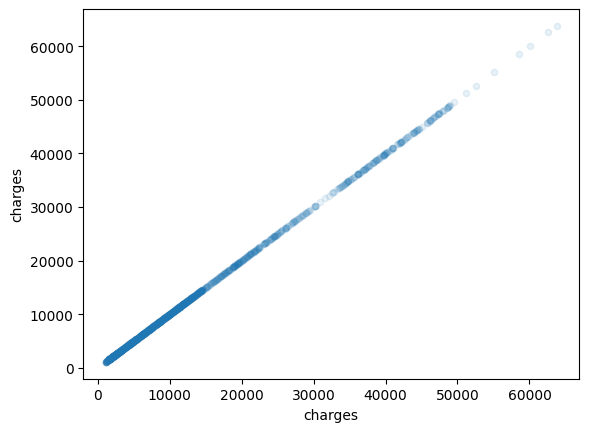

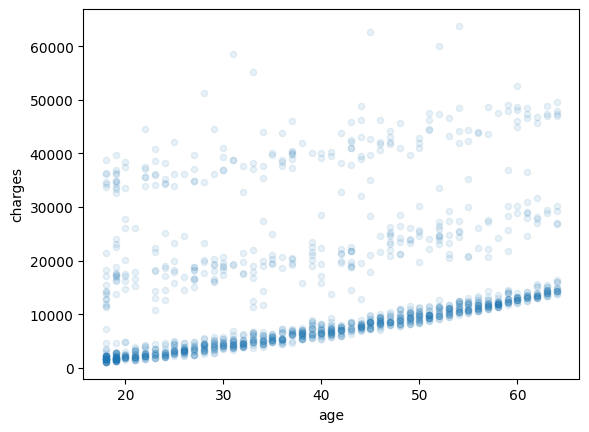

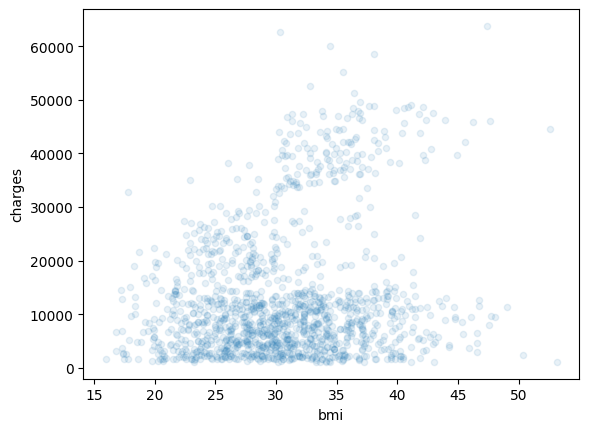

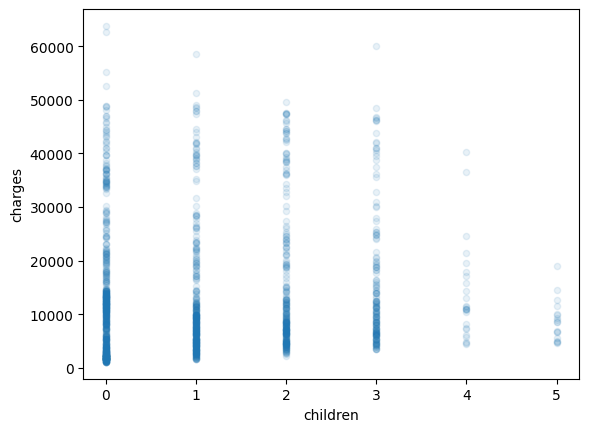

In [ ]:
from pandas.plotting import scatter_matrix
corr_matrix = insurance.corr(numeric_only=True)
corr_matrix = corr_matrix["charges"].sort_values(ascending=False)
for a in corr_matrix.index.tolist():
  insurance.plot(kind="scatter", x=a, y="charges",
             alpha=0.1)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)
insurance = train_set.drop("charges", axis=1)
features = insurance.columns.tolist()[:-1]
features.extend(["northeast", "northwest", "southeast", "southwest"])
insurance_test = test_set.drop("charges", axis=1)
insurance_labels = train_set["charges"].copy()
insurance_labels_test = test_set["charges"].copy()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_attribs = insurance.select_dtypes(include=['float', 'int']).columns.tolist()
cat_attribs = insurance.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_attribs[:-1]),
    ])
X_train = full_pipeline.fit_transform(insurance)
X_test = full_pipeline.fit_transform(insurance_test)
y_train = insurance_labels.values.reshape(-1, 1)
y_test = insurance_labels_test.values.reshape(-1, 1)
encoder = full_pipeline.named_transformers_['cat']
print(encoder.categories_)

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


## Gradient Descent

In [ ]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self, alpha):
    """
    Initialize the regressor
    """
    self.theta = None; # parameter vector;
    self.alpha = alpha; # learning rate
    self.cost  = []; # cost function

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    X_b = np.c_[np.ones((len(y_train), 1)), X_train]
    self.theta = np.random.randn(X_b.shape[1], 1)
    self.theta, self.cost = self.gradientDescent(X_b, y_train, self.theta, self.alpha, iters=1000)


  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    m = len(y_train)
    X_b = np.c_[np.ones((len(y_train), 1)), X_train]
    self.theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train);

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT:
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    m = len(y_train)
    costs = []
    for i in range(iters):
      gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train)
      theta = theta - alpha * gradients
      c = (1 / (2 * m)) * np.sum((X_train.dot(theta) - y_train) ** 2)
      costs.append(c)
    return(theta, costs)

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here
    X_test = np.c_[np.ones((len(X_test), 1)), X_test]
    return X_test.dot(self.theta)

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    if self.theta.all() == None: return "not trained yet"
    output = ""
    for f, t in zip(features, self.theta[1:].flatten()):
      output += str(f) + ": " + str(t) + '\n'
    return output

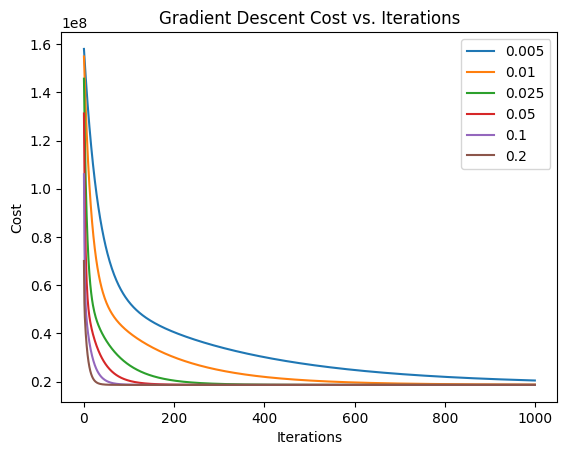

In [ ]:
# Your code goes here to call the instance of class MyLinearRegression
alphas = [0.005, 0.01, 0.025, 0.05, 0.1, 0.2]

for alpha in alphas:
    lin_reg = MyLinearRegression(alpha)
    lin_reg.fitUsingGradientDescent(X_train, y_train)
    plt.plot(range(1000), lin_reg.cost, label=alpha)

plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Gradient Descent Cost vs. Iterations")
plt.legend()
plt.show()

#Choosing a Learning Rate
We select a learning rate of 0.01 because it most optimizes training time and cost.

##Normal Equation



In [ ]:
myNormalEquationModel = MyLinearRegression(0.05)
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

##Comparison

In [ ]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
output = ""
for f, t in zip(features, mySGDModel.coef_.flatten()):
  output += str(f) + ": " + str(t) + '\n'
print(output)
print(mySGDModel_rmse)
print('\n')

myGradientDescentModel = MyLinearRegression(alpha=0.025)
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
y_predict = myGradientDescentModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
myGradientDescentModel_rmse = np.sqrt(mse)
print(myGradientDescentModel)
print(myGradientDescentModel_rmse)
print('\n')

myNormalEquationModel = MyLinearRegression(0.025)
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)
y_predict = myNormalEquationModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
myNormalEquationModel_rmse = np.sqrt(mse)
print(myNormalEquationModel)
print(myNormalEquationModel_rmse)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


age: 3584.32203289834
sex: 2042.486338998478
bmi: 524.9433242787985
children: 9.640038592299488
smoker: 23649.841367132307
northeast: -257.7762075181942
northwest: -531.674539404729
southeast: -685.5999203571828

5801.232613392512


age: 3615.2593475590634
sex: 2023.6612148120148
bmi: 516.3116532864159
children: 1.3677183642630164
smoker: 23656.28228959747
northeast: -201.81267458240563
northwest: -482.7994903717207
southeast: -638.1131690189666

5800.510079955987


age: 3614.975414827999
sex: 2036.2281228967186
bmi: 516.8902471991524
children: -18.59169164101887
smoker: 23651.12885576125
northeast: -370.6773262277975
northwest: -657.8642965646591
southeast: -809.7993541824831

5795.332533018757


##Presentation of Solution
We have evaluated three models of linear regression and have concluded that we can estimate with confidence medical costs within approximately $6000 per incident based on the following factors: age, sex, BMI, number of children, smoker status, and region. The most significant factors are, in order, smoker status, age, and sex. In particular, smokers, men, and older people tend to pay more. Moving forward, a comprehensive presentation of our findings can include an analysis of the potential causal factors driving our results.

##Sources
I used examples presented by Nhat Rich Nguyen in lecture for Machine Learning at UVA and *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* by Aurelien Geron in completing this assignment. I also referenced the Scikit-learn documentation.